In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [74]:
import util as u
%load_ext autoreload
%autoreload 2

In [2]:
vr = pd.read_csv('Data/video_review.csv')
# pprd = pd.read_csv('Data/play_player_role_data.csv')
# ppd = pd.read_csv('Data/player_punt_data.csv')
# pi = pd.read_csv('Data/play_information.csv')
# gd = pd.read_csv('Data/game_data.csv')

### pull out data for first injury in video_review table

In [4]:
vr.loc[0]

Season_Year                                   2016
GameKey                                          5
PlayID                                        3129
GSISID                                       31057
Player_Activity_Derived                   Tackling
Turnover_Related                                No
Primary_Impact_Type                 Helmet-to-body
Primary_Partner_GSISID                       32482
Primary_Partner_Activity_Derived           Tackled
Friendly_Fire                                   No
Name: 0, dtype: object

In [6]:
ngs_16_pre = pd.read_csv('NGS-2016-pre.csv', parse_dates=['Time'])
ngs_16_pre.sort_values(by='Time', ascending=True, inplace=True)

In [7]:
def get_play_info(gk, pid):
    return pi[(pi['GameKey'] == gk) & (pi['PlayID'] == pid)]

In [8]:
pi1 = get_play_info(5, 3129)

In [9]:
pi1

,Season_Year,Season_Type,GameKey,Game_Date,Week,PlayID,Game_Clock,YardLine,Quarter,Play_Type,Poss_Team,Home_Team_Visit_Team,Score_Home_Visiting,PlayDescription
35,2016,Pre,5,08/11/2016,2,3129,03:44,CHI 31,3,Punt,CHI,CHI-DEN,0 - 22,(3:44) (Punt formation) P.O'Donnell punts 58 y...


In [ ]:
def (gk, pid, ngs_df):
    

In [10]:
def get_play_ngs(gk, pid, df):
    new_df = df[(df['GameKey'] == gk) & (df['PlayID'] == pid)]
    new_df = new_df.drop(columns=['GameKey', 'PlayID', 'Season_Year'])
    return new_df

In [40]:
ngs1 = get_play_ngs(5, 3129, ngs_16_pre)
ngs1.reset_index(drop=True, inplace=True)

In [41]:
ngs1.head()

,GSISID,Time,x,y,dis,o,dir,Event
0,32460.0,2016-08-12 02:07:25.100,76.769997,24.270000,0.02,334.989990,313.079987,punt_play
1,31902.0,2016-08-12 02:07:25.100,81.160004,28.850000,0.02,256.940002,340.220001,punt_play
2,32776.0,2016-08-12 02:07:25.100,80.660004,43.320000,0.04,140.419998,293.029999,punt_play
3,32790.0,2016-08-12 02:07:25.100,84.389999,25.889999,0.04,218.240005,308.829987,punt_play
4,31079.0,2016-08-12 02:07:25.100,93.300003,27.129999,0.12,175.570007,265.540009,punt_play


In [42]:
len(ngs1)

5962

Note there is ~ 1 second of data missing for GSISID 31209 around 02:07:40, which is not the player that got injured (31057)

### Calculate distance from x & y

In [43]:
ngs1['dt'] = ngs1.groupby('GSISID')['Time'].diff()
ngs1['dt'] = ngs1['dt'].apply(lambda x: x.total_seconds())

ngs1['dx'] = ngs1.groupby('GSISID')['x'].diff()
ngs1['dy'] = ngs1.groupby('GSISID')['y'].diff()
ngs1['dist'] = np.sqrt(ngs1['dx']**2 + ngs1['dy']**2) * 0.9144

ngs1['speed'] = ngs1['dist'] / ngs1['dt']
ngs1['d_speed'] = ngs1.groupby('GSISID')['speed'].diff()
ngs1['accel'] = ngs1['d_speed'] / ngs1['dt']

In [44]:
ngs1.tail()

,GSISID,Time,x,y,dis,o,dir,Event,dt,dx,dy,dist,speed,d_speed,accel
5957,31915.0,2016-08-12 02:07:51.900,29.160000,5.40,0.09,10.200000,101.980003,play_submit,0.1,0.090000,-0.02,0.084304,0.843036,-0.075927,-0.759274
5958,32482.0,2016-08-12 02:07:51.900,36.320000,2.61,0.18,301.019989,32.540001,play_submit,0.1,0.090000,0.15,0.159955,1.599546,-0.079070,-0.790703
5959,31209.0,2016-08-12 02:07:51.900,34.950001,4.41,0.16,58.439999,143.809998,play_submit,0.1,0.100002,-0.13,0.149974,1.499741,0.168363,1.683631
5960,31057.0,2016-08-12 02:07:51.900,32.759998,1.94,0.10,219.080002,185.369995,play_submit,0.1,0.090000,-0.04,0.090058,0.900581,0.254007,2.540075
5961,32776.0,2016-08-12 02:07:51.900,40.610001,4.89,0.11,155.190002,156.259995,play_submit,0.1,0.010002,-0.11,0.100999,1.009991,0.431684,4.316837


In [45]:
ngs1_p1 = ngs1[ngs1['GSISID'] == 31057]

In [46]:
def plot_player_speed(gid):
    df = ngs1[ngs1['GSISID'] == gid]
    xs = df['Time']
    plt.plot(xs, df['speed'], label='Speed')
    plt.plot(xs, df['accel'], label='Accel', alpha=0.4)
    plt.title(f'Player ID {gid}')
    plt.legend();

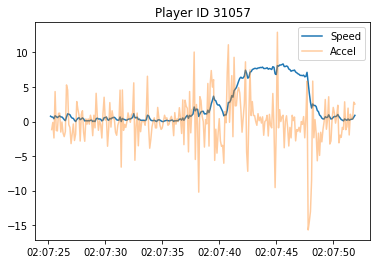

In [47]:
plot_player_speed(31057)

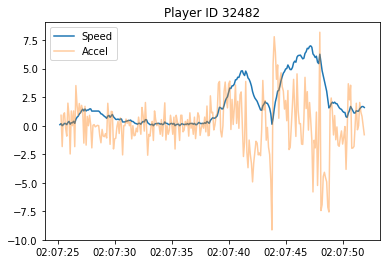

In [48]:
plot_player_speed(32482)

Does injured player experience the highest deceleration?

In [49]:
ngs1['accel'].describe()

count    5916.000000
mean        0.076367
std         4.499360
min       -29.509120
25%        -1.130122
50%         0.000000
75%         1.130364
max       268.335944
Name: accel, dtype: float64

In [51]:
ngs1_p1['accel'].describe()

count    2.670000e+02
mean     4.670167e-03
std      3.411310e+00
min     -1.568354e+01
25%     -1.495045e+00
50%     -2.298162e-13
75%      1.203802e+00
max      1.292479e+01
Name: accel, dtype: float64

No.

Need to clean up the accel's

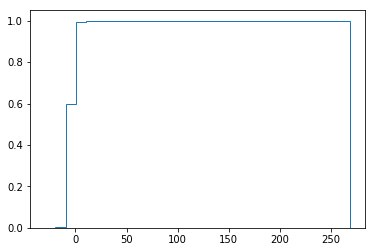

In [36]:
plt.hist(ngs1['accel'], cumulative=True, density=1, bins=30, histtype='step');

In [52]:
ngs1[ngs1['accel'] > 50]

,GSISID,Time,x,y,dis,o,dir,Event,dt,dx,dy,dist,speed,d_speed,accel
2138,33064.0,2016-08-12 02:07:34.300,64.199997,51.049999,2.94,161.490005,303.01001,NaN,0.1,-2.460007,1.599998,2.683359,26.833594,26.833594,268.335944


In [53]:
def get_player_xys(df, gid):
    return df[df['GSISID'] == gid]

In [54]:
temp = get_player_xys(ngs1, 33064.0)

In [69]:
temp.tail()

,GSISID,Time,x,y,dis,o,dir,Event,dt,dx,dy,dist,speed,d_speed,accel
2041,33064.0,2016-08-12 02:07:33.900,66.660004,49.450001,0.00,161.539993,40.470001,NaN,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2069,33064.0,2016-08-12 02:07:34.000,66.660004,49.450001,0.00,161.520004,53.549999,NaN,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2088,33064.0,2016-08-12 02:07:34.100,66.660004,49.450001,0.00,161.509995,58.540001,NaN,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2100,33064.0,2016-08-12 02:07:34.200,66.660004,49.450001,0.00,161.509995,57.470001,NaN,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2138,33064.0,2016-08-12 02:07:34.300,64.199997,51.049999,2.94,161.490005,303.010010,NaN,0.1,-2.460007,1.599998,2.683359,26.833594,26.833594,268.335944


In [63]:
for x in ngs1['GSISID'].unique():
    print(f"{x}, {stats.mode(ngs1[ngs1['GSISID'] == x]['accel'])[0][0]}")

32460.0, 0.0
31902.0, 0.0
32776.0, 0.0
32790.0, -13.515318346212846
31079.0, 0.0
26852.0, 0.0
32482.0, 0.0
31697.0, -0.9142465209960937
32136.0, 0.0
32471.0, 0.0
32477.0, -0.9143773269654133
32958.0, -13.166705757320107
27718.0, 0.0
32489.0, 0.0
31209.0, -11.445510748546761
31915.0, 0.0
28284.0, -13.607060032890693
31130.0, 0.0
28041.0, 0.0
33064.0, 0.0
31057.0, 0.0
32519.0, 0.0
30705.0, 0.0


In [64]:
stats.mode(ngs1[ngs1['GSISID'] == 33064]['accel'])

ModeResult(mode=array([0.]), count=array([88]))

In [65]:
ngs1_clean = ngs1[ngs1['accel'] < 50]

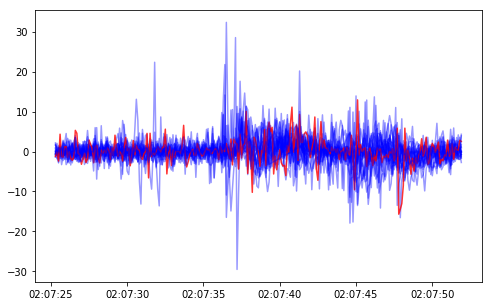

In [68]:
plt.figure(figsize=(8,5))
inj_id = 31057
for x in ngs1_clean['GSISID'].unique():
    if x == inj_id:
        c = 'r'
        a = 0.8
    else:
        c = 'b'
        a = 0.4
    df = ngs1_clean[ngs1_clean['GSISID'] == x]
    plt.plot(df['Time'], df['accel'], label=x, color=c, alpha=a)
#     plt.legend()

It's not just deceleration that determines injury

In [75]:
def calc_accel_play(gk, pid, ngs_df):
    ngs1 = ngs_df[(ngs_df['GameKey'] == gk) & (ngs_df['PlayID'] == pid)]
    ngs1 = ngs1.drop(columns=['GameKey', 'PlayID', 'Season_Year'])
    
    ngs1.reset_index(drop=True, inplace=True)    
    
    ngs1['dt'] = ngs1.groupby('GSISID')['Time'].diff()
    ngs1['dt'] = ngs1['dt'].apply(lambda x: x.total_seconds())

    ngs1['dx'] = ngs1.groupby('GSISID')['x'].diff()
    ngs1['dy'] = ngs1.groupby('GSISID')['y'].diff()
    ngs1['dist'] = np.sqrt(ngs1['dx']**2 + ngs1['dy']**2) * 0.9144

    ngs1['speed'] = ngs1['dist'] / ngs1['dt']
    ngs1['d_speed'] = ngs1.groupby('GSISID')['speed'].diff()
    ngs1['accel'] = ngs1['d_speed'] / ngs1['dt']
    
    return ngs1

In [84]:
gk2, pid2, inj_gid2 = vr.loc[1,['GameKey', 'PlayID', 'GSISID']]

In [85]:
inj_gid2

29343

In [83]:
ngs2 = calc_accel(gk2, pid2, ngs_16_pre)

In [86]:
ngs2['accel'].describe()

count    1.923900e+04
mean    -4.633280e-03
std      2.033748e+00
min     -3.138556e+01
25%     -9.468457e-01
50%     -1.290079e-12
75%      9.142465e-01
max      2.403140e+01
Name: accel, dtype: float64

/Users/kendra/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kendra/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.0000e+00, 2.0000e+00, 3.0000e+00, 4.2000e+01, 4.4300e+02,
        1.6589e+04, 2.0690e+03, 7.4000e+01, 9.0000e+00, 7.0000e+00]),
 array([-31.38556383, -25.84386722, -20.30217061, -14.760474  ,
         -9.21877739,  -3.67708077,   1.86461584,   7.40631245,
         12.94800906,  18.48970567,  24.03140228]),
 <a list of 10 Patch objects>)

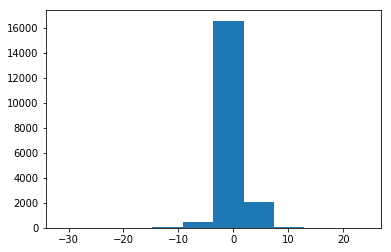

In [87]:
plt.hist(ngs2['accel'])

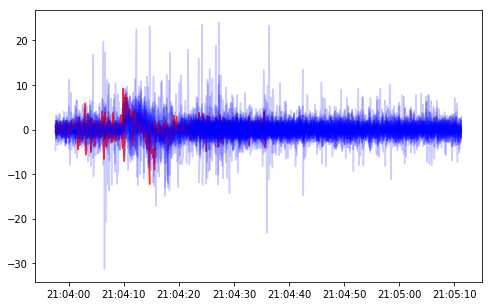

In [89]:
plt.figure(figsize=(8,5))
inj_id = inj_gid2
for x in ngs2['GSISID'].unique():
    if x == inj_id:
        c = 'r'
        a = 0.8
    else:
        c = 'b'
        a = 0.2
    df = ngs2[ngs2['GSISID'] == x]
    plt.plot(df['Time'], df['accel'], label=x, color=c, alpha=a)
#     plt.legend()

In [94]:
def calc_accel_ngs(filename):
    '''filename: NGS filename'''
    ngs1 = pd.read_csv(filename, parse_dates=['Time'])
    ngs1.sort_values(by='Time', ascending=True, inplace=True)    
    ngs1.reset_index(drop=True, inplace=True)    
    
    ngs1['dt'] = ngs1.groupby(['GameKey','PlayID','GSISID'])['Time'].diff()
    ngs1['dt'] = ngs1['dt'].apply(lambda x: x.total_seconds())

    ngs1['dx'] = ngs1.groupby(['GameKey','PlayID','GSISID'])['x'].diff()
    ngs1['dy'] = ngs1.groupby(['GameKey','PlayID','GSISID'])['y'].diff()
    ngs1['dist'] = np.sqrt(ngs1['dx']**2 + ngs1['dy']**2) * 0.9144

    ngs1['speed'] = ngs1['dist'] / ngs1['dt']
    ngs1['d_speed'] = ngs1.groupby(['GameKey','PlayID','GSISID'])['speed'].diff()
    ngs1['accel'] = ngs1['d_speed'] / ngs1['dt']
    
    return ngs1

In [95]:
def calc_accel_ngs_df(ngs_df):
#     ngs1 = pd.read_csv(filename, parse_dates=['Time'])
    ngs1 = ngs_df
    ngs1.sort_values(by='Time', ascending=True, inplace=True)    
    ngs1.reset_index(drop=True, inplace=True)    
    
    ngs1['dt'] = ngs1.groupby(['GameKey','PlayID','GSISID'])['Time'].diff()
    ngs1['dt'] = ngs1['dt'].apply(lambda x: x.total_seconds())

    ngs1['dx'] = ngs1.groupby(['GameKey','PlayID','GSISID'])['x'].diff()
    ngs1['dy'] = ngs1.groupby(['GameKey','PlayID','GSISID'])['y'].diff()
    ngs1['dist'] = np.sqrt(ngs1['dx']**2 + ngs1['dy']**2) * 0.9144

    ngs1['speed'] = ngs1['dist'] / ngs1['dt']
    ngs1['d_speed'] = ngs1.groupby(['GameKey','PlayID','GSISID'])['speed'].diff()
    ngs1['accel'] = ngs1['d_speed'] / ngs1['dt']
    
    return ngs1

In [96]:
ngs_16_pre_accel = calc_accel_ngs_df(ngs_16_pre)

In [98]:
ngs_16_pre_accel.tail()

,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event,dt,dx,dy,dist,speed,d_speed,accel
6824896,2016,56,3194,27866.0,2016-09-02 04:36:10.800,61.369999,53.430000,0.23,67.610001,110.269997,play_submit,0.1,0.209999,-0.099998,0.212683,2.126827,0.039661,0.396610
6824897,2016,56,3194,32443.0,2016-09-02 04:36:10.800,76.879997,53.369999,0.16,95.040001,172.479996,play_submit,0.1,0.040001,-0.150002,0.141955,1.419546,0.060212,0.602122
6824898,2016,56,3194,32852.0,2016-09-02 04:36:10.800,69.639999,41.830002,0.15,268.570007,354.670013,play_submit,0.1,-0.050003,0.140003,0.135939,1.359390,-0.154191,-1.541909
6824899,2016,56,3194,33056.0,2016-09-02 04:36:10.800,75.239998,46.900002,0.06,54.410000,11.230000,play_submit,0.1,-0.020004,0.050003,0.049246,0.492460,-0.696262,-6.962618
6824900,2016,56,3194,29123.0,2016-09-02 04:36:10.800,48.060001,30.690001,0.16,32.660000,135.649994,play_submit,0.1,0.120003,-0.100000,0.142836,1.428360,0.069038,0.690377


In [99]:
ngs_16_pre_accel.sample()

,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event,dt,dx,dy,dist,speed,d_speed,accel
3361094,2016,33,2845,31847.0,2016-08-21 01:34:45.200,88.209999,0.62,0.41,91.0,151.880005,NaN,0.1,0.120003,-0.39,0.373116,3.731163,-0.293223,-2.932228


In [101]:
ngs_rand = get_play_ngs(33, 2845, ngs_16_pre_accel)

<module 'matplotlib.pyplot' from '/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

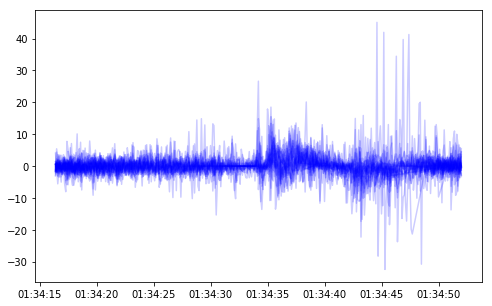

In [116]:
u.plot_all_accels(ngs_rand)